**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [ ]:
## If you are using the data by mounting the google drive, use the following :

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Motivation: To create a multiclass classification model using a custom convolutional neural network in tensorflow

**Data Summary:**

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

a) Actinic keratosis

b) Basal cell carcinoma

c) Dermatofibroma

d) Melanoma

e) Nevus

f) Pigmented benign keratosis

g) Seborrheic keratosis

h) Squamous cell carcinoma

i) Vascular lesion


In [ ]:
###  Importing Skin Cancer Data
### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Load using keras.preprocessing Let's load these images off disk using the helpful image_dataset_from_directory utility.

Create a dataset Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Will write train dataset here with 80 % and 20 % split.
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  label_mode="int",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
# Creating Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  label_mode="int",
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
#Listing out all the classes of skin canacer train data
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


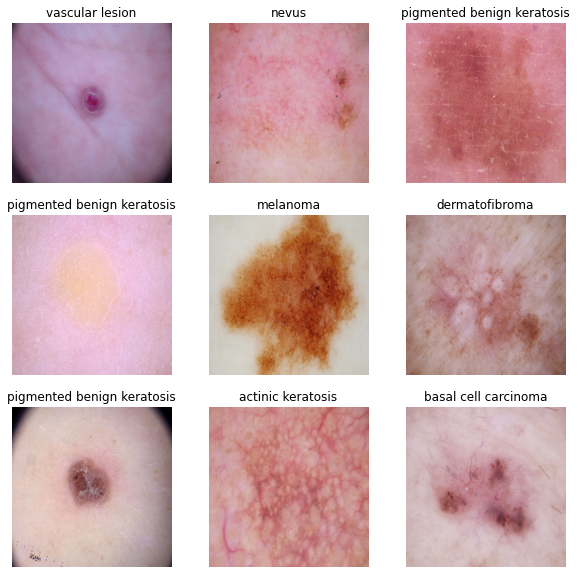

In [ ]:
# Visualize the data 

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

# Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

# Dataset.prefetch() overlaps data preprocessing and model execution while training

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the Data The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y:(normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_ds))

In [ ]:
### Create the Model1

In [ ]:
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D ,BatchNormalization, Rescaling, InputLayer


In [ ]:
model = Sequential()
model.add(InputLayer((180,180,3)))
model.add(Rescaling(1./255))

model.add(Conv2D(32, 3, activation='relu',padding='same' ))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, activation='relu',padding='same' ))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))

model.add(Dense(9, activation='softmax'))


In [ ]:
# Compile the model
## Choose appropriate optimizer and loss function for model training
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64800)             0

In [ ]:
# Train the model
epochs = 20
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    epochs=20
    )

Epoch 1/20
56/56 [==============================] - 55s 781ms/step - loss: 2.6854 - accuracy: 0.2165 - val_loss: 1.8536 - val_accuracy: 0.3132
Epoch 2/20
56/56 [==============================] - 5s 86ms/step - loss: 1.6585 - accuracy: 0.4219 - val_loss: 1.6559 - val_accuracy: 0.4340
Epoch 3/20
56/56 [==============================] - 5s 82ms/step - loss: 1.4614 - accuracy: 0.4961 - val_loss: 1.4324 - val_accuracy: 0.5235
Epoch 4/20
56/56 [==============================] - 5s 83ms/step - loss: 1.3284 - accuracy: 0.5301 - val_loss: 1.3773 - val_accuracy: 0.5257
Epoch 5/20
56/56 [==============================] - 5s 83ms/step - loss: 1.3546 - accuracy: 0.5296 - val_loss: 1.4647 - val_accuracy: 0.4989
Epoch 6/20
56/56 [==============================] - 5s 83ms/step - loss: 1.1365 - accuracy: 0.5910 - val_loss: 1.3764 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 5s 83ms/step - loss: 0.9257 - accuracy: 0.6713 - val_loss: 1.4418 - val_accuracy: 0.5235
Epoch 8/20


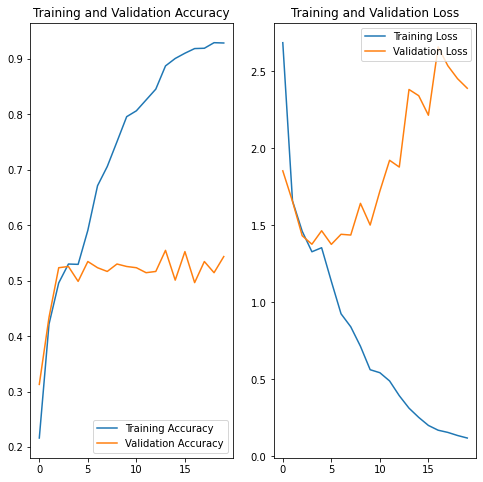

In [ ]:
# Visualizing training results
epochs = 20
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings on the first base model** : From above plot we can clearly see overfiting for Model1

In [ ]:
# Model Overfit or Underfit?
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


# Thus we can clearly that model Overfit and we need to chose right data augumentation strategy

14/14 [==============================] - 0s 30ms/step - loss: 2.3897 - accuracy: 0.5436
Accuracy:  0.9408482313156128
Validation Accuracy:  0.5436241626739502
Loss:  0.1180356964468956
Validation Loss 2.389674186706543


In [ ]:
# Now for Model2 we will add dataaugmentation where we can use multiple views of images.
data_aug = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

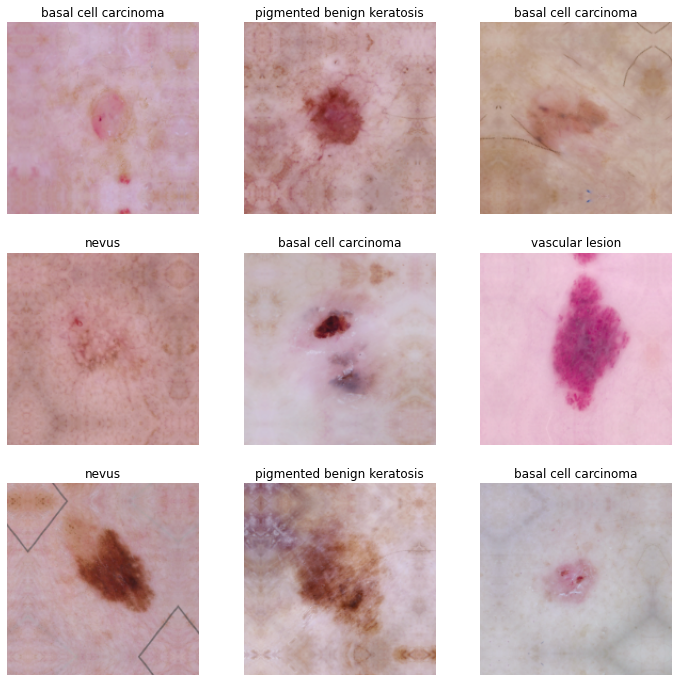

In [ ]:
# visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# Model 2 Creation
# We can use dropouts inorder to overcome overfitting issue


In [ ]:
num_classes = 9
model = Sequential([ data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(MaxPooling2D())
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D())

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))

model.add(Dense(9, activation='softmax'))

In [ ]:
# Compile the model
## Choose appropriate optimizer and loss function for model training
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
# Train the model
epochs = 20
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    epochs=20
    )

Epoch 1/20
56/56 [==============================] - 7s 97ms/step - loss: 2.6202 - accuracy: 0.2243 - val_loss: 1.8545 - val_accuracy: 0.3557
Epoch 2/20
56/56 [==============================] - 5s 94ms/step - loss: 1.8371 - accuracy: 0.3203 - val_loss: 1.8031 - val_accuracy: 0.3110
Epoch 3/20
56/56 [==============================] - 5s 94ms/step - loss: 1.7033 - accuracy: 0.3772 - val_loss: 1.6068 - val_accuracy: 0.4340
Epoch 4/20
56/56 [==============================] - 5s 95ms/step - loss: 1.5763 - accuracy: 0.4353 - val_loss: 1.5237 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 5s 94ms/step - loss: 1.5287 - accuracy: 0.4593 - val_loss: 1.6800 - val_accuracy: 0.4004
Epoch 6/20
56/56 [==============================] - 5s 94ms/step - loss: 1.5765 - accuracy: 0.4141 - val_loss: 1.4796 - val_accuracy: 0.4787
Epoch 7/20
56/56 [==============================] - 5s 94ms/step - loss: 1.4923 - accuracy: 0.4581 - val_loss: 1.5799 - val_accuracy: 0.4206
Epoch 8/20
56

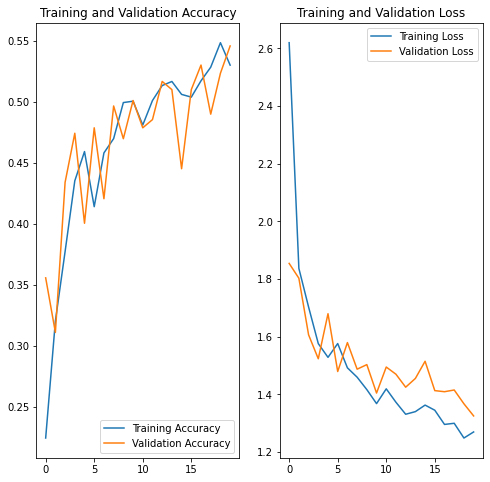

In [ ]:
# Visualizing training results
epochs = 20
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings**: We don't see much improvements with respect to accuracy from the base model, but we can definitely see the overfitting issue fading away due to data augmentation But again, judging based on just 20 epochs won't give us proper conclusions

In [ ]:
# Model Overfit or Underfit?
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


# Thus we can clearly that model is no more overfitted now but accuracy is very less which should be improved

14/14 [==============================] - 0s 29ms/step - loss: 1.3254 - accuracy: 0.5459
Accuracy:  0.5518973469734192
Validation Accuracy:  0.5458613038063049
Loss:  1.2187050580978394
Validation Loss 1.3254491090774536


*Find the distribution of classes in the training dataset . *

Class distribution: Examine the current class distribution in the training dataset

***Context***: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
path_list=[]
lesion_list=[]
for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    print(j)

/content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset/Train/actinic keratosis/ISIC_0025803.jpg
/content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset/Train/actinic keratosis/ISIC_0027668.jpg
/content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset/Train/actinic keratosis/ISIC_0027334.jpg
/content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset/Train/actinic keratosis/ISIC_0027447.jpg
/content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset/Train/actinic keratosis/ISIC_0026984.jpg
/content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset/Train/actinic keratosis/ISIC_0026857.jpg
/content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset/Train/actinic keratosis/ISIC_0027254.jpg
/content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset/Train/actinic keratosis/ISIC_0026905.jpg
/content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset/Train/actinic keratosis/ISIC_0027172.jpg
/content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset/Train/actinic keratosis/ISIC_00

In [ ]:
path_list=[]
lesion_list=[]
for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    path_list.append(str(j))
    lesion_list.append(i)

dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Colab_Notebooks/Skin_C...,actinic keratosis
1,/content/gdrive/MyDrive/Colab_Notebooks/Skin_C...,actinic keratosis
2,/content/gdrive/MyDrive/Colab_Notebooks/Skin_C...,actinic keratosis
3,/content/gdrive/MyDrive/Colab_Notebooks/Skin_C...,actinic keratosis
4,/content/gdrive/MyDrive/Colab_Notebooks/Skin_C...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Colab_Notebooks/Skin_C...,vascular lesion
2235,/content/gdrive/MyDrive/Colab_Notebooks/Skin_C...,vascular lesion
2236,/content/gdrive/MyDrive/Colab_Notebooks/Skin_C...,vascular lesion
2237,/content/gdrive/MyDrive/Colab_Notebooks/Skin_C...,vascular lesion


<BarContainer object of 9 artists>

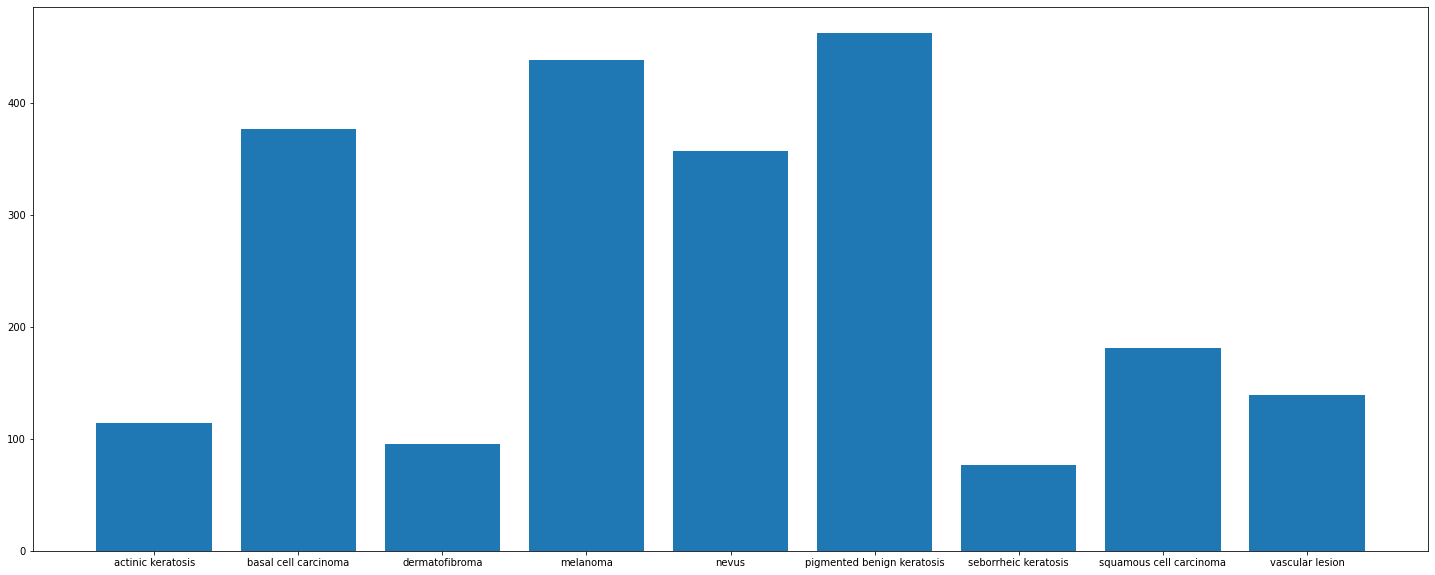

In [ ]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

*Questions Asked below with answers *

Q1. Which class has the least number of samples?

Ans : Seborrheic keratosis is having the lowest distribution

Q2. Which classes dominate the data in terms of the proportionate number of samples?

Ans : Pigmented Benign keratosis is having the highest distribution of data

**# Rectify the class imbalance**

Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

1) Instantiate a Pipeline object pointing to a directory containing your initial image data set. 2) Define a number of operations to perform on this data set using your Pipeline object. 3) Execute these operations by calling the Pipeline’s sample() method.

In [ ]:
import Augmentor
path_to_training_dataset="/content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset/Train/"

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDB75C21E50>: 100%|██████████| 500/500 [00:23<00:00, 20.92 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDB75B21F50>: 100%|██████████| 500/500 [00:22<00:00, 21.76 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDB75B373D0>: 100%|██████████| 500/500 [00:21<00:00, 23.53 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDB75EF3F10>: 100%|██████████| 500/500 [01:43<00:00,  4.84 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7FDB75C21C50>: 100%|██████████| 500/500 [01:40<00:00,  4.98 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDBE088ECD0>: 100%|██████████| 500/500 [00:20<00:00, 24.35 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDC887EDF90>: 100%|██████████| 500/500 [00:46<00:00, 10.64 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDB75EF91D0>: 100%|██████████| 500/500 [00:20<00:00, 23.85 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDB75BCE450>: 100%|██████████| 500/500 [00:20<00:00, 24.11 Samples/s]


All the output files are stored inside output folder of each sub class

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Let's create new path list and lesion list with new augmented data

In [ ]:
from glob import glob

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

**Check the counts now after class imbalance **

In [ ]:
new_df['Label'].value_counts()

nevus                         500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
melanoma                      500
dermatofibroma                500
pigmented benign keratosis    500
basal cell carcinoma          500
actinic keratosis             500
Name: Label, dtype: int64

So now each subclass has 500 images created by augmentor library . We will use this data to create our final model

In [ ]:
#Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Create a training dataset

In [ ]:
data_dir_train = "/content/gdrive/MyDrive/Colab_Notebooks/Skin_Cancer_Dataset/Train/" 
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  label_mode="int",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**Creating a validation dataset**

In [ ]:
# Creating Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  label_mode="int",
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Model 3**

# Creating model with batch normalization

In [ ]:
model_normal = Sequential()
model_normal.add(InputLayer((180,180,3)))
model_normal.add(Rescaling(1./255))

model_normal.add(Conv2D(32, (3,3) , padding='same' ))
model_normal.add(Conv2D(32, (3,3) , padding='same' ))
model_normal.add(BatchNormalization())
model_normal.add(Activation('relu'))
model_normal.add(MaxPooling2D(pool_size=(2,2)))

model_normal.add(Conv2D(64, (3,3)))
model_normal.add(Conv2D(64, (3,3)))
model_normal.add(BatchNormalization())
model_normal.add(Activation('relu'))
model_normal.add(MaxPooling2D(pool_size=(2,2)))

model_normal.add(Dropout(0.25))

model_normal.add(Conv2D(128, (3,3)))
model_normal.add(BatchNormalization())
model_normal.add(Activation('relu'))
model_normal.add(MaxPooling2D(pool_size=(2,2)))
model_normal.add(Dropout(0.25))

model_normal.add(Flatten())
model_normal.add(Dense(512, activation='relu'))
model_normal.add(Dense(256, activation='relu'))
model_normal.add(Dropout(0.25))

model_normal.add(Dense(9, activation='softmax'))

model_normal.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                  

In [ ]:
# Compile the model
## Choose appropriate optimizer and loss function for model training
model_normal.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model_normal.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                  

In [ ]:
# Train the model
epochs = 30
history = model_normal.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    epochs=30
    )

Epoch 1/30
169/169 [==============================] - 54s 293ms/step - loss: 5.0399 - accuracy: 0.2784 - val_loss: 2.4299 - val_accuracy: 0.0846
Epoch 2/30
169/169 [==============================] - 49s 284ms/step - loss: 1.5365 - accuracy: 0.4249 - val_loss: 1.9696 - val_accuracy: 0.2821
Epoch 3/30
169/169 [==============================] - 49s 280ms/step - loss: 1.3429 - accuracy: 0.5096 - val_loss: 1.8279 - val_accuracy: 0.3808
Epoch 4/30
169/169 [==============================] - 49s 280ms/step - loss: 1.2119 - accuracy: 0.5516 - val_loss: 1.2971 - val_accuracy: 0.5041
Epoch 5/30
169/169 [==============================] - 49s 280ms/step - loss: 1.0194 - accuracy: 0.6269 - val_loss: 1.7708 - val_accuracy: 0.4558
Epoch 6/30
169/169 [==============================] - 49s 279ms/step - loss: 0.9654 - accuracy: 0.6491 - val_loss: 1.9005 - val_accuracy: 0.4313
Epoch 7/30
169/169 [==============================] - 49s 279ms/step - loss: 0.8079 - accuracy: 0.7020 - val_loss: 0.9863 - val_ac

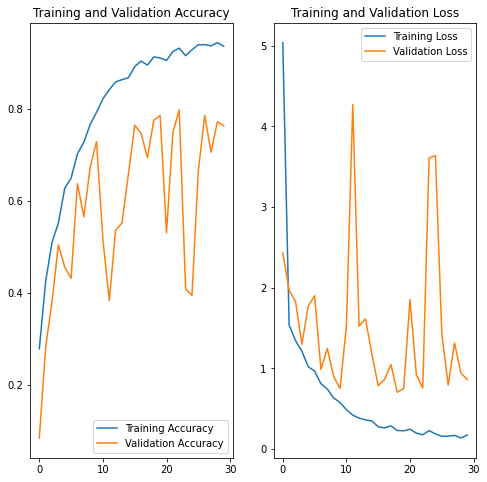

In [ ]:
# Visualizing training results
epochs = 30
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Final Findings :**

Did you get rid of underfitting/overfitting? Did class rebalance help? The class rebalance helped in reducing overfititng of the data and thus the loass is beng reduced But it reduced the Acurracy very low

**Model 1**
Initially we tried without any data augmentation , dropouts and we saw oferfitted model clearly.

**Model 2** 
We used data augmentation and dropouts which removed overfitting completely.

**Model 3**
At last we tried Batch Normalization and Augumentation which really helped in carry forward and handled overfitting , improved accuracy by more than 93 %  and validation accuracy upto 77 %